In [1]:
!nvidia-smi

Tue Jul  6 12:07:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   30C    P8     7W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn
sklearn.__version__

'0.20.0'

In [3]:
import os
import time
import requests
import pandas as pd
import numpy as np
from pickle import load
from datetime import timedelta
import matplotlib.pyplot as plt

In [4]:
from sodapy import Socrata
from sklearn.metrics import mean_absolute_error, mean_squared_error#,mean_absolute_percentage_error

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer
from attention import Attention

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [ ]:
#LOAD

In [ ]:
#Merge, remove null and na imputation

In [7]:
#today = "2021-05-27"
today = "2021-12-02"

In [8]:
#Vacunats

In [9]:
dfVac = pd.read_csv("data_flow/CASOS_VAC" + today + ".csv")

print(dfVac.shape)
print(dfVac.columns)

print(dfVac["regio_codi"].unique())
print(dfVac["regio"].unique())
print(dfVac["data"].iloc[-5:])
print((dfVac["regio_codi"]==0).sum())
print(dfVac["dosi"].unique())

dfVac["recompte"] = pd.to_numeric(dfVac["recompte"])
dfVac["data"] = pd.to_datetime(dfVac["data"])
dfVac.sort_values("data",ascending=True, inplace=True)

print(dfVac[dfVac["regio_codi"]==7803].shape)

(6966, 6)
Index(['data', 'regio_codi', 'regio', 'dosi', 'no_vacunat', 'recompte'], dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803    0]
['LLEIDA' 'CAMP DE TARRAGONA' "TERRES DE L'EBRE" 'GIRONA'
 'CATALUNYA CENTRAL' 'ALT PIRINEU I ARAN' 'METROPOLITANA SUD'
 'METROPOLITANA NORD' 'BARCELONA CIUTAT' 'No classificat']
6961    2021-11-30
6962    2021-11-30
6963    2021-11-30
6964    2021-11-30
6965    2021-11-30
Name: data, dtype: object
679
[1 2 3]
(727, 6)


In [10]:
# calculate cases by computing the mean of the last 7 days reported cases

dfVac_r_6200_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6200_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7803_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7803_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6700_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6700_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7801_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7801_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6400_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6400_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7802_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7802_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6300_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6300_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_0_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_0_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==2)][["data","recompte"]]

print(dfVac_r_0_v1.shape, dfVac_r_7803_v1.shape,dfVac_r_6700_v1.shape,dfVac_r_7801_v1.shape,
     dfVac_r_6400_v1.shape,dfVac_r_7802_v1.shape,dfVac_r_6200_v1.shape,dfVac_r_6100_v1.shape,
     dfVac_r_7100_v1.shape,dfVac_r_6300_v1.shape)

(327, 2) (338, 2) (335, 2) (335, 2) (333, 2) (338, 2) (332, 2) (323, 2) (310, 2) (318, 2)


In [11]:
dfVacAll = None
dfVacAll = pd.merge(dfVac_r_6200_v1,dfVac_r_7803_v1,how="left", on="data",suffixes=("_r_6200_v1","_r_7803_v1"))

dfVacAll = pd.merge(dfVacAll, dfVac_r_6700_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v1'}, inplace = True)

In [12]:
#dfVacAll.plot(x="data", figsize=(15,8))

In [13]:
dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7803_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7803_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6700_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6200_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6200_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v2'}, inplace = True)

dfVacAll.tail()

,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_0_v2,recompte_r_7803_v2,recompte_r_6700_v2,recompte_r_7801_v2,recompte_r_6400_v2,recompte_r_7802_v2,recompte_r_6200_v2,recompte_r_6100_v2,recompte_r_7100_v2,recompte_r_6300_v2
327,2021-11-26,362,1361.0,366.0,913.0,1062.0,1652,152.0,454.0,56.0,...,87.0,2954.0,621.0,1291.0,980.0,2303.0,576.0,474.0,77.0,198.0
328,2021-11-27,42,848.0,74.0,679.0,101.0,845,56.0,4.0,3.0,...,33.0,2010.0,25.0,281.0,501.0,726.0,289.0,3.0,2.0,3.0
329,2021-11-28,38,514.0,49.0,487.0,45.0,335,32.0,5.0,1.0,...,8.0,1447.0,21.0,182.0,16.0,301.0,6.0,1.0,3.0,1.0
330,2021-11-29,351,1268.0,214.0,749.0,119.0,1377,120.0,369.0,40.0,...,68.0,2045.0,247.0,1364.0,192.0,1136.0,308.0,167.0,38.0,81.0
331,2021-11-30,623,904.0,271.0,779.0,985.0,1302,124.0,482.0,57.0,...,81.0,1695.0,345.0,1702.0,964.0,1624.0,557.0,353.0,55.0,96.0


In [14]:
#NAN
print(len(dfVacAll.columns))
print(dfVacAll.columns)
print(dfVacAll.isnull().sum(axis=0))
dfVacAll.fillna(0,inplace=True)
#dfVacAll = dfVacAll.iloc[10:]
print(dfVacAll.isnull().sum(axis=0))

21
Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
data                   0
recompte_r_6200_v1     0
recompte_r_7803_v1     1
recompte_r_6700_v1     2
recompte_r_7801_v1     2
recompte_r_6400_v1     1
recompte_r_7802_v1     0
recompte_r_0_v1        8
recompte_r_6100_v1    11
recompte_r_7100_v1    24
recompte_r_6300_v1    16
recompte_r_0_v2       39
recompte_r_7803_v2    23
recompte_r_6700_v2    28
recompte_r_7801_v2    22
recompte_r_6400_v2    29
recompte_r_7802_v2    21
recompte_r_6200_v2    31
recompte_r_6100_v2    36
recompte

In [15]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfVacAll.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfVacAll.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfVacAll.iloc[i-j,k]
        zn.append(acc/7)

    dfVacAll[cols[k] + "_7"] = zn
    
dfVacAll = dfVacAll[["data",
       'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2', 
       'recompte_r_7803_v2',
       'recompte_r_6700_v2', 'recompte_r_7801_v2', 'recompte_r_6400_v2',
       'recompte_r_7802_v2', 'recompte_r_0_v2', 'recompte_r_6100_v2',
       'recompte_r_7100_v2', 'recompte_r_6300_v2',       
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7',
       'recompte_r_6700_v1_7', 'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7',
       'recompte_r_7802_v1_7', 'recompte_r_0_v1_7', 'recompte_r_6100_v1_7',
       'recompte_r_7100_v1_7', 'recompte_r_6300_v1_7', 'recompte_r_6200_v2_7', 
       'recompte_r_7803_v2_7',
       'recompte_r_6700_v2_7', 'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7',
       'recompte_r_7802_v2_7', 'recompte_r_0_v2_7', 'recompte_r_6100_v2_7',
       'recompte_r_7100_v2_7', 'recompte_r_6300_v2_7',                  
                    ]]

print(len(dfVacAll.columns))
dfVacAll

Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
41


,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_6200_v2_7,recompte_r_7803_v2_7,recompte_r_6700_v2_7,recompte_r_7801_v2_7,recompte_r_6400_v2_7,recompte_r_7802_v2_7,recompte_r_0_v2_7,recompte_r_6100_v2_7,recompte_r_7100_v2_7,recompte_r_6300_v2_7
0,2020-12-27,112,58.0,87.0,84.0,76.0,161,0.0,67.0,79.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-12-30,172,441.0,295.0,401.0,127.0,648,17.0,363.0,91.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-12-31,192,664.0,228.0,232.0,80.0,569,4.0,503.0,113.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-02,3,603.0,402.0,110.0,233.0,615,0.0,46.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-03,1,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,2021-11-26,362,1361.0,366.0,913.0,1062.0,1652,152.0,454.0,56.0,...,402.571429,2331.142857,320.142857,930.428571,430.428571,1188.285714,61.428571,370.714286,48.571429,88.571429
328,2021-11-27,42,848.0,74.0,679.0,101.0,845,56.0,4.0,3.0,...,442.142857,2288.857143,319.285714,943.571429,498.714286,1194.142857,60.857143,370.714286,48.571429,88.571429
329,2021-11-28,38,514.0,49.0,487.0,45.0,335,32.0,5.0,1.0,...,441.857143,2329.285714,319.000000,945.857143,498.571429,1186.857143,60.142857,370.571429,48.714286,88.714286
330,2021-11-29,351,1268.0,214.0,749.0,119.0,1377,120.0,369.0,40.0,...,426.714286,2303.428571,326.000000,1061.571429,514.142857,1257.000000,63.285714,373.285714,49.142857,94.285714


In [16]:
#Incidence x regio

In [17]:
dfInc = pd.read_csv("data_flow/CASOS_UCI" + today + ".csv")
dfInc = dfInc[["data","regiosanitariacodi","casos_confirmat"]].groupby(["data","regiosanitariacodi"]).sum().reset_index()

print(dfInc.shape)
print(dfInc.columns)
print("Codis:",dfInc["regiosanitariacodi"].unique())
#print("Regions:",dfInc["regiosanitariadescripcio"].unique())
print("Total casos regio 0:", (dfInc["regiosanitariacodi"]==0).sum())
print("data min",dfInc["data"].min())
print("data max",dfInc["data"].max())
print("Total days",pd.to_datetime(dfInc["data"].max())-pd.to_datetime(dfInc["data"].min()))

dfInc["numcasos"] = pd.to_numeric(dfInc["casos_confirmat"])
dfInc["data"] = pd.to_datetime(dfInc["data"])
dfInc = dfInc[["data","regiosanitariacodi","numcasos"]]
dfInc.sort_values("data",ascending=True, inplace=True)
print(dfInc.columns)
print(dfInc[dfInc["regiosanitariacodi"]==7803].shape)

(5769, 3)
Index(['data', 'regiosanitariacodi', 'casos_confirmat'], dtype='object')
Codis: [6100 6200 6300 6400 6700 7100 7801 7802 7803]
Total casos regio 0: 0
data min 2020-03-01
data max 2021-12-01
Total days 640 days 00:00:00
Index(['data', 'regiosanitariacodi', 'numcasos'], dtype='object')
(641, 3)


In [18]:
# calculate cases by computing the mean of the last 7 days reported cases
dfInc_r_0 = dfInc[dfInc["regiosanitariacodi"]==0][["data","numcasos"]]
dfInc_r_7803 = dfInc[dfInc["regiosanitariacodi"]==7803][["data","numcasos"]]
dfInc_r_6700 = dfInc[dfInc["regiosanitariacodi"]==6700][["data","numcasos"]]
dfInc_r_7801 = dfInc[dfInc["regiosanitariacodi"]==7801][["data","numcasos"]]
dfInc_r_6400 = dfInc[dfInc["regiosanitariacodi"]==6400][["data","numcasos"]]
dfInc_r_7802 = dfInc[dfInc["regiosanitariacodi"]==7802][["data","numcasos"]]
dfInc_r_6200 = dfInc[dfInc["regiosanitariacodi"]==6200][["data","numcasos"]]
dfInc_r_6100 = dfInc[dfInc["regiosanitariacodi"]==6100][["data","numcasos"]]
dfInc_r_7100 = dfInc[dfInc["regiosanitariacodi"]==7100][["data","numcasos"]]
dfInc_r_6300 = dfInc[dfInc["regiosanitariacodi"]==6300][["data","numcasos"]]

print(dfInc_r_0.shape,dfInc_r_7803.shape,dfInc_r_6700.shape,dfInc_r_7801.shape)

if dfInc_r_0.shape[0]==0:
    dfInc = dfInc_r_7803
else:
    dfInc = pd.merge(dfInc_r_0,dfInc_r_7803,how="left", on="data",suffixes=("_r_0","_r_7803"))
dfInc = pd.merge(dfInc,dfInc_r_6700,how="left", on="data",suffixes=("_r_7803","_r_6700"))
dfInc = pd.merge(dfInc,dfInc_r_7801,how="left", on="data",suffixes=("_r_6700","_r_7801"))
dfInc = pd.merge(dfInc,dfInc_r_6400,how="left", on="data",suffixes=("_r_7801","_r_6400"))
dfInc = pd.merge(dfInc,dfInc_r_7802,how="left", on="data",suffixes=("_r_6400","_r_7802"))
dfInc = pd.merge(dfInc,dfInc_r_6200,how="left", on="data",suffixes=("_r_7802","_r_6200"))
dfInc = pd.merge(dfInc,dfInc_r_6100,how="left", on="data",suffixes=("_r_6200","_r_6100"))
dfInc = pd.merge(dfInc,dfInc_r_7100,how="left", on="data",suffixes=("_r_6100","_r_7100"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_7100","_r_6300"))
dfInc['numcasos_r_6300'] = dfInc['numcasos']
dfInc = dfInc[['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300']]
print(dfInc.columns)
display(dfInc.tail())

(0, 2) (641, 2) (641, 2) (641, 2)
Index(['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300'],
      dtype='object')


,data,numcasos_r_7803,numcasos_r_6700,numcasos_r_7801,numcasos_r_6400,numcasos_r_7802,numcasos_r_6200,numcasos_r_6100,numcasos_r_7100,numcasos_r_6300
636,2021-11-27,102,48,65,133,248,69,62,10,17
637,2021-11-28,79,45,57,98,159,42,48,3,16
638,2021-11-29,282,130,304,223,399,101,102,23,14
639,2021-11-30,233,104,178,169,379,43,46,9,18
640,2021-12-01,130,66,99,112,160,48,47,11,14


In [19]:
#res = dfInc[["numcasos_r_7803","numcasos_r_7802","numcasos_r_7801"]].sum(axis=1)
#res.plot()

In [20]:
#NAN
print(dfInc.isnull().sum(axis=0))
#dfInc.interpolate(method='polynomial', limit_direction='forward', axis=0, order=2,inplace=True)
#dfInc = dfInc.iloc[10:]
dfInc.fillna(0,inplace=True)
print(dfInc.isnull().sum(axis=0))

data               0
numcasos_r_7803    0
numcasos_r_6700    0
numcasos_r_7801    0
numcasos_r_6400    0
numcasos_r_7802    0
numcasos_r_6200    0
numcasos_r_6100    0
numcasos_r_7100    0
numcasos_r_6300    0
dtype: int64
data               0
numcasos_r_7803    0
numcasos_r_6700    0
numcasos_r_7801    0
numcasos_r_6400    0
numcasos_r_7802    0
numcasos_r_6200    0
numcasos_r_6100    0
numcasos_r_7100    0
numcasos_r_6300    0
dtype: int64


In [21]:
#dfInc.plot(x="data",figsize=(15,8))
#print(dfInc.isnull().sum(axis=0))
#print(dfInc.columns)
#plt.show()

In [22]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfInc.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfInc.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInc.iloc[i-j,k]
        zn.append(acc/7)

    dfInc[cols[k] + "_7"] = zn
    
dfInc = dfInc[["data",
       'numcasos_r_7803', 'numcasos_r_6700',
       'numcasos_r_7801', 'numcasos_r_6400', 'numcasos_r_7802',
       'numcasos_r_6200', 'numcasos_r_6100', 'numcasos_r_7100',
       'numcasos_r_6300',            
       'numcasos_r_7803_7', 'numcasos_r_6700_7',
       'numcasos_r_7801_7', 'numcasos_r_6400_7', 'numcasos_r_7802_7',
       'numcasos_r_6200_7', 'numcasos_r_6100_7', 'numcasos_r_7100_7',
       'numcasos_r_6300_7']]
dfInc

Index(['data', 'numcasos_r_7803', 'numcasos_r_6700', 'numcasos_r_7801',
       'numcasos_r_6400', 'numcasos_r_7802', 'numcasos_r_6200',
       'numcasos_r_6100', 'numcasos_r_7100', 'numcasos_r_6300'],
      dtype='object')


,data,numcasos_r_7803,numcasos_r_6700,numcasos_r_7801,numcasos_r_6400,numcasos_r_7802,numcasos_r_6200,numcasos_r_6100,numcasos_r_7100,numcasos_r_6300,numcasos_r_7803_7,numcasos_r_6700_7,numcasos_r_7801_7,numcasos_r_6400_7,numcasos_r_7802_7,numcasos_r_6200_7,numcasos_r_6100_7,numcasos_r_7100_7,numcasos_r_6300_7
0,2020-03-01,4,0,0,1,2,0,0,0,0,0.571429,0.000000,0.000000,0.142857,0.285714,0.000000,0.000000,0.000000,0.000000
1,2020-03-02,2,1,1,0,0,0,0,0,0,0.857143,0.142857,0.142857,0.142857,0.285714,0.000000,0.000000,0.000000,0.000000
2,2020-03-03,5,1,3,1,2,0,0,0,0,1.571429,0.285714,0.571429,0.285714,0.571429,0.000000,0.000000,0.000000,0.000000
3,2020-03-04,3,1,1,1,1,0,0,0,0,2.000000,0.428571,0.714286,0.428571,0.714286,0.000000,0.000000,0.000000,0.000000
4,2020-03-05,10,2,2,2,3,0,0,0,0,3.428571,0.714286,1.000000,0.714286,1.142857,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2021-11-27,102,48,65,133,248,69,62,10,17,244.000000,114.571429,199.714286,198.142857,343.571429,81.857143,79.285714,17.571429,30.714286
637,2021-11-28,79,45,57,98,159,42,48,3,16,248.285714,115.571429,198.714286,199.714286,349.714286,82.142857,80.000000,16.857143,31.142857
638,2021-11-29,282,130,304,223,399,101,102,23,14,241.857143,114.000000,196.285714,203.142857,342.857143,80.285714,78.285714,16.428571,25.857143
639,2021-11-30,233,104,178,169,379,43,46,9,18,227.857143,110.714286,184.571429,193.857143,344.428571,73.142857,67.571429,14.142857,22.857143


In [23]:
#Forecasting predictions!!

In [24]:
mapRegId = {
 '0000': 'No classificat',
 '7803': 'BARCELONA CIUTAT',
 '6700': 'CATALUNYA CENTRAL',
 '7801': 'METROPOLITANA SUD',
 '6400': 'GIRONA',
 '7802': 'METROPOLITANA NORD',
 '6200': 'CAMP DE TARRAGONA',
 '6100': 'LLEIDA',
 '7100': 'ALT PIRINEU I ARAN',
 '6300': "TERRES DE L'EBRE"    
}

In [25]:
selCodisReg = ['6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802','7803']

In [26]:
modelNames = [
    "best_model_region_shallow.02122021.",
    "best_model_region_vacc.02122021.shallow.",
    "best_model_region_vacc_mean7.no_attn.02122021.",
]

#    "best_model_region_shallow_attn.02122021.",
#    "best_model_region_vacc_mean7.02122021."

In [27]:
#Get cls

In [28]:
preds_all = []
for cls in modelNames:
    for cod in selCodisReg:

        fname = cls+cod   
        print("\n" + str(cod) + " " + mapRegId[str(cod)] + "\n")
        print(fname)


        #Read data
        dfAll = pd.merge(dfInc[["data",'numcasos_r_'+cod,'numcasos_r_'+cod+'_7']],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("","")
                        )
        dfAll.fillna(0,inplace=True)

        #Remove last days 
        dfAll = dfAll.iloc[:-1]
        dateIni = str(dfAll.iloc[-1]["data"])[:-9]
        dateFi = str(dfAll.iloc[0]["data"])[:-9]
        print(dateIni, dateFi)

        #Convert data to format (rows,timepoints,features)
        if "vacc." in fname:
            cols = ['numcasos_r_'+cod,'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2']
        elif "mean7" in fname:
            cols = [
                   'numcasos_r_'+cod, 'numcasos_r_'+cod+'_7', 
                   'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2', 
                   'recompte_r_'+cod+'_v1_7', 'recompte_r_'+cod+'_v2_7']            
        else:
            cols = ['numcasos_r_'+cod]
            
        print(cols)
        ncols=len(cols)
        res = series_to_supervised(dfAll.loc[:,cols].values,21,21,dropnan=False)   

        #Patition train/test
        data_X = res.iloc[:,:(21*ncols)].values.reshape(-1,21,ncols)
        real_all = res.iloc[:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)  

        # normalize features
        scalers_X = []
        for i in range(data_X.shape[-1]):
            print(fname + "_scaler_tr_X_" + str(i)+'.pkl')
            scaler = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))
            data_X[:,:,i] = scaler.transform(data_X[:,:,i])
        scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))

        #Evaluate
        preds_region = []
        for cc in range(5):
            print("Loading...", "models/"+ fname + "_" + str(cc) +'.h5')
            model = tf.keras.models.load_model("models/"+ fname + "_" + str(cc) +'.h5')
            preds = model.predict(data_X)
            preds_region.append(scaler_y.inverse_transform(preds))
        preds_all.append(preds_region)
        preds_region = np.array(preds_region).reshape(5,data_X.shape[0],data_X.shape[1])
        np.save(os.getcwd()+"/results/res_"+ fname +'.npy', preds_region)


6100 LLEIDA

best_model_region_shallow.02122021.6100
2021-11-30 2020-03-01
['numcasos_r_6100']
best_model_region_shallow.02122021.6100_scaler_tr_X_0.pkl
Loading... models/best_model_region_shallow.02122021.6100_0.h5
Loading... models/best_model_region_shallow.02122021.6100_1.h5
Loading... models/best_model_region_shallow.02122021.6100_2.h5
Loading... models/best_model_region_shallow.02122021.6100_3.h5
Loading... models/best_model_region_shallow.02122021.6100_4.h5

6200 CAMP DE TARRAGONA

best_model_region_shallow.02122021.6200
2021-11-30 2020-03-01
['numcasos_r_6200']
best_model_region_shallow.02122021.6200_scaler_tr_X_0.pkl
Loading... models/best_model_region_shallow.02122021.6200_0.h5
Loading... models/best_model_region_shallow.02122021.6200_1.h5
Loading... models/best_model_region_shallow.02122021.6200_2.h5
Loading... models/best_model_region_shallow.02122021.6200_3.h5
Loading... models/best_model_region_shallow.02122021.6200_4.h5

6300 TERRES DE L'EBRE

best_model_region_shallow.0

Loading... models/best_model_region_vacc.02122021.shallow.7100_3.h5
Loading... models/best_model_region_vacc.02122021.shallow.7100_4.h5

7801 METROPOLITANA SUD

best_model_region_vacc.02122021.shallow.7801
2021-11-30 2020-03-01
['numcasos_r_7801', 'recompte_r_7801_v1', 'recompte_r_7801_v2']
best_model_region_vacc.02122021.shallow.7801_scaler_tr_X_0.pkl
best_model_region_vacc.02122021.shallow.7801_scaler_tr_X_1.pkl
best_model_region_vacc.02122021.shallow.7801_scaler_tr_X_2.pkl
Loading... models/best_model_region_vacc.02122021.shallow.7801_0.h5
Loading... models/best_model_region_vacc.02122021.shallow.7801_1.h5
Loading... models/best_model_region_vacc.02122021.shallow.7801_2.h5
Loading... models/best_model_region_vacc.02122021.shallow.7801_3.h5
Loading... models/best_model_region_vacc.02122021.shallow.7801_4.h5

7802 METROPOLITANA NORD

best_model_region_vacc.02122021.shallow.7802
2021-11-30 2020-03-01
['numcasos_r_7802', 'recompte_r_7802_v1', 'recompte_r_7802_v2']
best_model_region_vacc


7801 METROPOLITANA SUD

best_model_region_vacc_mean7.no_attn.02122021.7801
2021-11-30 2020-03-01
['numcasos_r_7801', 'numcasos_r_7801_7', 'recompte_r_7801_v1', 'recompte_r_7801_v2', 'recompte_r_7801_v1_7', 'recompte_r_7801_v2_7']
best_model_region_vacc_mean7.no_attn.02122021.7801_scaler_tr_X_0.pkl
best_model_region_vacc_mean7.no_attn.02122021.7801_scaler_tr_X_1.pkl
best_model_region_vacc_mean7.no_attn.02122021.7801_scaler_tr_X_2.pkl
best_model_region_vacc_mean7.no_attn.02122021.7801_scaler_tr_X_3.pkl
best_model_region_vacc_mean7.no_attn.02122021.7801_scaler_tr_X_4.pkl
best_model_region_vacc_mean7.no_attn.02122021.7801_scaler_tr_X_5.pkl
Loading... models/best_model_region_vacc_mean7.no_attn.02122021.7801_0.h5
Loading... models/best_model_region_vacc_mean7.no_attn.02122021.7801_1.h5
Loading... models/best_model_region_vacc_mean7.no_attn.02122021.7801_2.h5
Loading... models/best_model_region_vacc_mean7.no_attn.02122021.7801_3.h5
Loading... models/best_model_region_vacc_mean7.no_attn.0212

In [28]:
# EVALUATION 
# Old.validation: 2021-03-27
# Old.test: 2021-05-27
# Test: 2021-10-01


best_model_region_shallow.02122021.
6100
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 21.22 MAPE: 0.5 CUM-MAE: 223.32 CUM-MAPE: 0.18 R2: 0.7
7 55 MAE: 23.46 MAPE: 0.52 CUM-MAE: 261.68 CUM-MAPE: 0.28 R2: 0.65
14 48 MAE: 25.13 MAPE: 0.53 CUM-MAE: 261.81 CUM-MAPE: 0.32 R2: 0.55
21 41 MAE: 30.63 MAPE: 0.55 CUM-MAE: 371.65 CUM-MAPE: 0.34 R2: 0.16
ALL 61 MAE: 24.21 MAPE: 0.43 CUM-MAE: 414.81 CUM-MAPE: 0.27 R2: 0.67
6200
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 20.42 MAPE: 0.55 CUM-MAE: 220.63 CUM-MAPE: 0.19 R2: 0.79
7 55 MAE: 23.14 MAPE: 0.58 CUM-MAE: 256.7 CUM-MAPE: 0.26 R2: 0.69
14 48 MAE: 25.47 MAPE: 0.6 CUM-MAE: 253.16 CUM-MAPE: 0.24 R2: 0.36
21 41 MAE: 30.91 MAPE: 0.58 CUM-MAE: 356.25 CUM-MAPE: 0.42 R2: -0.29
ALL 61 MAE: 26.78 MAPE: 0.48 CUM-MAE: 480.75 CUM-MAPE: 0.34 R2: 0.52
6300
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 8.66 MAPE: 0.58 CUM-MAE: 155.44 CUM-MAPE: 0.35 R2: 0.27
7 55 MAE: 7.1 MAPE: 0.54 CUM-MAE: 80.91 CUM-MAPE: 0.18 R2: 0.4
14 48 MAE: 7.03 MAPE: 0.

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PR

ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 86.57 MAPE: 0.77 CUM-MAE: 785.08 CUM-MAPE: 0.41 R2: 0.84
7 55 MAE: 102.85 MAPE: 0.61 CUM-MAE: 1055.05 CUM-MAPE: 0.3 R2: 0.85
14 48 MAE: 121.47 MAPE: 0.61 CUM-MAE: 1411.87 CUM-MAPE: 0.41 R2: 0.74
21 41 MAE: 120.37 MAPE: 0.64 CUM-MAE: 1033.58 CUM-MAPE: 0.35 R2: -0.09
ALL 61 MAE: 130.89 MAPE: 0.53 CUM-MAE: 2043.8 CUM-MAPE: 0.35 R2: 0.42
7803
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 65.88 MAPE: 1.01 CUM-MAE: 629.16 CUM-MAPE: 0.23 R2: -0.53
7 55 MAE: 66.43 MAPE: 1.99 CUM-MAE: 723.68 CUM-MAPE: 0.97 R2: 0.8
14 48 MAE: 68.78 MAPE: 1.57 CUM-MAE: 518.2 CUM-MAPE: 0.53 R2: 0.71
21 41 MAE: 78.56 MAPE: 1.43 CUM-MAE: 584.31 CUM-MAPE: 0.45 R2: -0.12
ALL 61 MAE: 74.14 MAPE: 0.59 CUM-MAE: 874.48 CUM-MAPE: 0.5 R2: 0.03

best_model_region_vacc.02122021.shallow.
6100
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 16.6 MAPE: 0.66 CUM-MAE: 190.02 CUM-MAPE: 0.38 R2: 0.73
7 55 MAE: 17.44 MAPE: 0.66 CUM-MAE: 153.75 CUM-MAPE: 0.52 R2: 0.68
14 48 MAE: 

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PR

ALL 54 MAE: 4.42 MAPE: 0.37 CUM-MAE: 94.79 CUM-MAPE: 0.31 R2: 0.55
7801
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 36.43 MAPE: 0.72 CUM-MAE: 217.61 CUM-MAPE: 0.34 R2: 0.75
7 55 MAE: 36.99 MAPE: 0.68 CUM-MAE: 259.96 CUM-MAPE: 0.37 R2: 0.8
14 48 MAE: 49.73 MAPE: 0.76 CUM-MAE: 371.96 CUM-MAPE: 0.38 R2: 0.79
21 41 MAE: 61.22 MAPE: 0.99 CUM-MAE: 424.59 CUM-MAPE: 0.78 R2: 0.52
ALL 61 MAE: 38.87 MAPE: 0.43 CUM-MAE: 515.01 CUM-MAPE: 0.44 R2: 0.76
7802
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 45.61 MAPE: 0.52 CUM-MAE: 211.43 CUM-MAPE: 0.14 R2: 0.88
7 55 MAE: 53.69 MAPE: 0.52 CUM-MAE: 499.87 CUM-MAPE: 0.32 R2: 0.89
14 48 MAE: 76.03 MAPE: 0.52 CUM-MAE: 711.57 CUM-MAPE: 0.33 R2: 0.79
21 41 MAE: 98.22 MAPE: 0.73 CUM-MAE: 742.76 CUM-MAPE: 0.6 R2: 0.68
ALL 61 MAE: 55.33 MAPE: 0.31 CUM-MAE: 950.53 CUM-MAPE: 0.33 R2: 0.89
7803
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 42.71 MAPE: 1.23 CUM-MAE: 267.82 CUM-MAPE: 0.35 R2: 0.76
7 55 MAE: 47.14 MAPE: 1.17 CUM-MAE: 366.42 CUM-MAPE: 0.

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


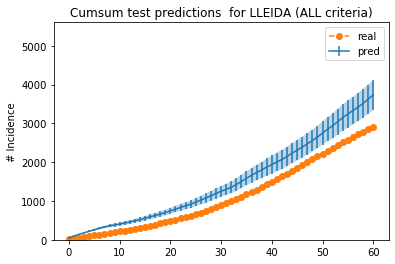

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


6200
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 12.61 MAPE: 0.66 CUM-MAE: 222.87 CUM-MAPE: 0.38 R2: 0.81
7 55 MAE: 12.06 MAPE: 0.47 CUM-MAE: 88.97 CUM-MAPE: 0.18 R2: 0.77
14 48 MAE: 18.61 MAPE: 0.68 CUM-MAE: 165.49 CUM-MAPE: 0.47 R2: 0.51
21 41 MAE: 24.59 MAPE: 0.95 CUM-MAE: 276.06 CUM-MAPE: 0.88 R2: 0.18
ALL 61 MAE: 13.94 MAPE: 0.36 CUM-MAE: 125.26 CUM-MAPE: 0.31 R2: 0.73
61 61 61


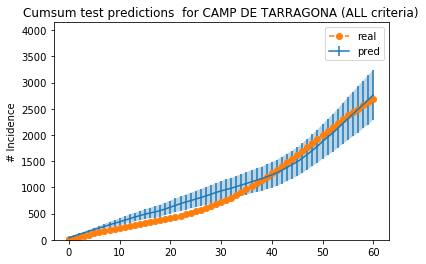

6300
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 6.44 MAPE: 0.65 CUM-MAE: 54.79 CUM-MAPE: 0.24 R2: 0.48
7 55 MAE: 6.5 MAPE: 0.62 CUM-MAE: 23.88 CUM-MAPE: 0.1 R2: 0.35
14 48 MAE: 7.6 MAPE: 0.76 CUM-MAE: 98.23 CUM-MAPE: 0.43 R2: 0.18
21 41 MAE: 9.39 MAPE: 0.92 CUM-MAE: 168.04 CUM-MAPE: 0.73 R2: 0.21
ALL 61 MAE: 4.6 MAPE: 0.29 CUM-MAE: 62.38 CUM-MAPE: 0.28 R2: 0.4
61 61 61


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


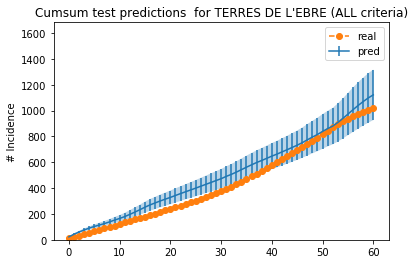

6400
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 21.86 MAPE: 0.34 CUM-MAE: 96.58 CUM-MAPE: 0.11 R2: 0.87
7 55 MAE: 26.03 MAPE: 0.33 CUM-MAE: 242.3 CUM-MAPE: 0.2 R2: 0.88
14 48 MAE: 35.56 MAPE: 0.41 CUM-MAE: 317.43 CUM-MAPE: 0.27 R2: 0.82
21 41 MAE: 46.14 MAPE: 0.69 CUM-MAE: 370.19 CUM-MAPE: 0.59 R2: 0.77


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


ALL 61 MAE: 30.43 MAPE: 0.29 CUM-MAE: 407.16 CUM-MAPE: 0.25 R2: 0.82
61 61 61


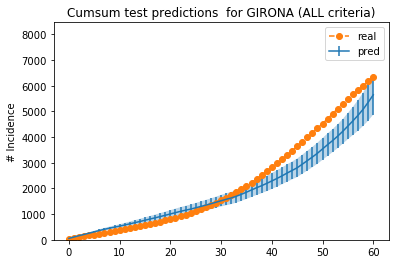

6700
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 19.68 MAPE: 0.48 CUM-MAE: 210.72 CUM-MAPE: 0.16 R2: 0.79
7 55 MAE: 19.72 MAPE: 0.63 CUM-MAE: 228.46 CUM-MAPE: 0.31 R2: 0.83
14 48 MAE: 27.57 MAPE: 0.77 CUM-MAE: 267.62 CUM-MAPE: 0.59 R2: 0.62
21 41 MAE: 36.46 MAPE: 1.01 CUM-MAE: 316.56 CUM-MAPE: 1.05 R2: 0.24
ALL 61 MAE: 21.7 MAPE: 0.41 CUM-MAE: 350.86 CUM-MAPE: 0.46 R2: 0.76
61 61 61


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


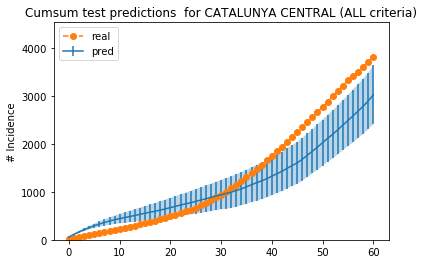

7100
ALL data: 2020-03-01 2021-11-30 640 640
NUM zeros: 7
1 54 MAE: 4.34 MAPE: 1.17 CUM-MAE: 23.95 CUM-MAPE: 0.21 R2: 0.68
7 48 MAE: 4.86 MAPE: 1.32 CUM-MAE: 27.49 CUM-MAPE: 0.35 R2: 0.6
14 41 MAE: 6.33 MAPE: 1.53 CUM-MAE: 42.53 CUM-MAPE: 0.95 R2: 0.36
21 34 MAE: 6.8 MAPE: 1.12 CUM-MAE: 42.53 CUM-MAPE: 0.33 R2: -0.01
ALL 54 MAE: 3.92 MAPE: 0.43 CUM-MAE: 31.8 CUM-MAPE: 0.31 R2: 0.6
54 54 54


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


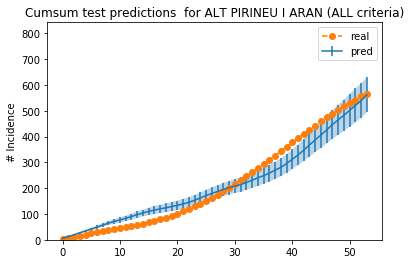

7801
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 39.78 MAPE: 1.09 CUM-MAE: 932.97 CUM-MAPE: 0.96 R2: 0.83
7 55 MAE: 28.12 MAPE: 0.46 CUM-MAE: 145.3 CUM-MAPE: 0.14 R2: 0.86
14 48 MAE: 35.98 MAPE: 0.47 CUM-MAE: 298.92 CUM-MAPE: 0.2 R2: 0.82
21 41 MAE: 55.3 MAPE: 1.02 CUM-MAE: 483.86 CUM-MAPE: 1.0 R2: 0.58
ALL 61 MAE: 30.15 MAPE: 0.36 CUM-MAE: 216.61 CUM-MAPE: 0.36 R2: 0.85
61 61 61


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


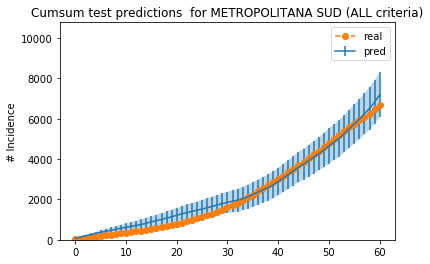

7802
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 39.33 MAPE: 0.52 CUM-MAE: 232.71 CUM-MAPE: 0.24 R2: 0.9
7 55 MAE: 46.62 MAPE: 0.62 CUM-MAE: 454.14 CUM-MAPE: 0.57 R2: 0.91
14 48 MAE: 71.78 MAPE: 0.77 CUM-MAE: 685.1 CUM-MAPE: 0.73 R2: 0.81
21 41 MAE: 107.73 MAPE: 1.36 CUM-MAE: 1472.1 CUM-MAPE: 1.52 R2: 0.54
ALL 61 MAE: 50.32 MAPE: 0.46 CUM-MAE: 618.71 CUM-MAPE: 0.59 R2: 0.86
61 61 61


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


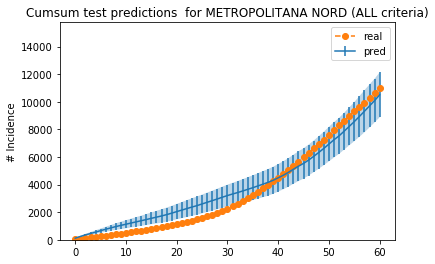

7803
ALL data: 2020-03-01 2021-11-30 640 640
1 61 MAE: 40.37 MAPE: 1.46 CUM-MAE: 742.79 CUM-MAPE: 0.73 R2: 0.84
7 55 MAE: 33.75 MAPE: 0.96 CUM-MAE: 391.94 CUM-MAPE: 0.54 R2: 0.87
14 48 MAE: 43.87 MAPE: 1.19 CUM-MAE: 580.5 CUM-MAPE: 0.68 R2: 0.88

ERROR!!
7803
Step: 20
MAPE: 3.252147262998382
[172.1741485595703 147.65086364746094 123.8375473022461 130.4246063232422
 192.30271911621094 198.57110595703125 186.7315216064453
 158.68861389160156 151.05374145507812 129.59127807617188
 128.63450622558594 169.80816650390625 168.8695526123047 184.1573028564453
 179.53536987304688 173.11572265625 146.46139526367188 134.43612670898438
 170.83489990234375 191.5908966064453 196.58938598632812
 182.98171997070312 168.8671875 144.0850830078125 131.27896118164062
 164.5032501220703 187.96080017089844 197.4353790283203 185.93038940429688
 171.3953094482422 148.030029296875 138.17916870117188 150.57208251953125
 224.61392211914062 239.5385284423828 228.19229125976562
 207.31973266601562 167.1620025634765

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


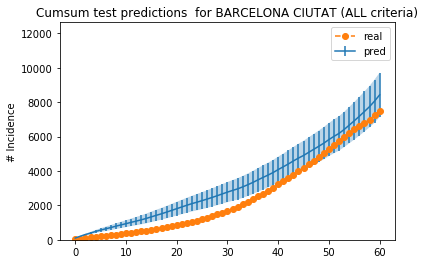

,cls,region,dayPred,num,mae,mape,mae_s,mape_s,maeAcc,mapeAcc,r2
0,best_model_region_shallow.02122021.,6100,1,61,21.22,0.50,23.28,0.37,223.32,0.18,0.70
1,best_model_region_shallow.02122021.,6100,7,61,23.46,0.52,24.52,0.37,261.68,0.28,0.65
2,best_model_region_shallow.02122021.,6100,14,61,25.13,0.53,24.89,0.45,261.81,0.32,0.55
3,best_model_region_shallow.02122021.,6100,21,61,30.63,0.55,27.05,0.33,371.65,0.34,0.16
4,best_model_region_shallow.02122021.,6100,-1,61,24.21,0.43,17.63,0.20,414.81,0.27,0.67
...,...,...,...,...,...,...,...,...,...,...,...
130,best_model_region_vacc_mean7.no_attn.02122021.,7803,1,61,40.37,1.46,31.43,3.43,742.79,0.73,0.84
131,best_model_region_vacc_mean7.no_attn.02122021.,7803,7,61,33.75,0.96,31.53,2.43,391.94,0.54,0.87
132,best_model_region_vacc_mean7.no_attn.02122021.,7803,14,61,43.87,1.19,31.56,2.92,580.50,0.68,0.88
133,best_model_region_vacc_mean7.no_attn.02122021.,7803,21,61,85.67,3.25,39.11,9.87,1783.26,2.07,0.68


In [82]:
plot = False
perfAll = []
for cls in modelNames[:]:
    print()
    print(cls)
    for cod in selCodisReg:
        print(cod)
        
        #Read data
        dfAll = pd.merge(dfInc[["data",'numcasos_r_'+cod,'numcasos_r_'+cod+'_7']],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("",""))
        dfAll.fillna(0,inplace=True)
        dfAll = dfAll.iloc[:-1]
        dateFi = str(dfAll.iloc[-1]["data"])[:-9]
        dateIni = str(dfAll.iloc[0]["data"])[:-9]
        
        #Preds data
        fname = cls+cod
        res = np.load("results/res_"+ fname +'.npy')
        
        resMean = np.nanmean(res, axis=0)
        resMean[np.isnan(resMean)]=0
        resStd = np.nanstd(res, axis=0)
        resStd[np.isnan(resStd)]=0
        resStd[resMean<0]=0
        resMean[resMean<0]=0
        
        
        print("ALL data:", dateIni, dateFi, len(dfAll),len(resMean))
        
        #Performance
        #ctte = dateIni
        #ctte = "2021-05-27"
        ctte = "2021-10-01"
        dayIni = dfAll[dfAll.iloc[:,0]>=ctte].iloc[0,0]
        ini = dfAll.iloc[:,0]>=ctte
        real = dfAll.loc[ini]
        real = real.iloc[:,1].astype(float)
        
        ix = np.logical_not(real==0)
        if np.sum(real==0)>0:
            print("NUM zeros:",np.sum(real==0))

        #real[real==0]=1 #To avoid errors (div_zero)!!
        real = real.loc[ix] #To avoid errors (div_zero)!!
        pred = resMean[ini,:].astype(float)
        pred = pred[ix]
        pred_s = resStd[ini,:].astype(float)
        pred_s = pred_s[ix]
        
        if len(real)!= len(pred):
            print()
            print("ERROR in SIZES:")
            print("TEST data:", ctte, dateFi, len(pred), len(real))
            break
        
        for j in [0,6,13,20]:        
            result = []          
            for i in range(pred.shape[0]):
                if i+j < len(real):
                    p = pred[i,j]
                    r = real.iloc[i+j]
                    result.append([dayIni+timedelta(days=j)+timedelta(days=j),i,j,p,r])
            result = np.array(result)
                
            #Daily
            mae = np.nanmean(np.abs(result[:,4]-result[:,3]))
            mape = np.nanmean(np.abs(result[:,4]-result[:,3])/(result[:,4]+1e-5))
            mae_s = np.nanstd(np.abs(result[:,4]-result[:,3]))
            mape_s = np.nanstd(np.abs(result[:,4]-result[:,3])/(result[:,4]+1e-5))            
            r2 = np.corrcoef(result[:,4].astype(float),result[:,3].astype(float))[0,1]
            
            if mape > 2:
                print()
                print("ERROR!!")
                print(cod)
                print("Step:", j)
                print("MAPE:", mape)
                print(result[:,3])
                print(result[:,4])
                print()
                
            #CumSum
            realAcc = np.nancumsum(result[:,4])
            predAcc = np.nancumsum(result[:,3])
            maeAcc = np.nanmean(np.abs(realAcc-predAcc))
            mapeAcc = np.nanmean(np.abs(realAcc-predAcc)/(realAcc+1e-5))
                
            print(j+1, len(result), 
                  "MAE:",np.round(mae,2),
                  "MAPE:",np.round(mape,2),
                  "CUM-MAE:",np.round(maeAcc,2),
                  "CUM-MAPE:", np.round(mapeAcc,2),
                  "R2:", np.round(r2,2)
                 )

                
            if plot and j in [0,6,13,20] and cls == 'best_model_region_vacc_mean7.no_attn.02122021.':
                plt.plot(result[:,3],label="pred")
                plt.plot(result[:,4],label="real")
                plt.title("Test predictions at " + str(j+1) + "day for "+str(mapRegId[cod]))
                plt.ylabel("# Incidence")
                plt.legend()
                plt.show()
                
            perfAll.append([cls,cod,j+1,len(real), np.round(mae,2), np.round(mape,2),
                            np.round(mae_s,2), np.round(mape_s,2),
                            np.round(maeAcc,2),np.round(mapeAcc,2),np.round(r2,2)])

        #Performance of summing all 21 predictions during the test period
        result = []
        for i in range(pred.shape[0]):            
            p=0
            ps=0
            r=0
            dim=0 
            for j in range(21):
                if i+j < len(real):
                    p += pred[i,j]
                    ps += pred_s[i,j]
                    r += real.iloc[i+j]
                    dim += 1
            result.append([dayIni+timedelta(days=j)+timedelta(days=j),i,p/dim,r/dim,ps/dim])
            
        result = np.array(result)

        #Daily
        mae = np.mean(np.abs(result[:,3]-result[:,2]))
        mape = np.mean(np.abs(result[:,3]-result[:,2])/(result[:,3]+1e-5))
        mae_s = np.std(np.abs(result[:,3]-result[:,2]))
        mape_s = np.std(np.abs(result[:,3]-result[:,2])/(result[:,3]+1e-5))        
        r2 = np.corrcoef(result[:,3].astype(float),result[:,2].astype(float))[0,1]

        #CumSum
        realAcc = np.nancumsum(result[:,3])
        predAcc = np.nancumsum(result[:,2])
        predAcc_s = np.nancumsum(result[:,4])
        maeAcc = np.nanmean(np.abs(realAcc-predAcc))
        mapeAcc = np.nanmean(np.abs(realAcc-predAcc)/(realAcc+1e-5))        
        perfAll.append([cls,cod,-1,len(real), np.round(mae,2), np.round(mape,2),
                        np.round(mae_s,2), np.round(mape_s,2),
                        np.round(maeAcc,2),np.round(mapeAcc,2),np.round(r2,2)]) 
        
        print("ALL", len(result), 
              "MAE:",np.round(mae,2),
              "MAPE:",np.round(mape,2),
              "CUM-MAE:",np.round(maeAcc,2),
              "CUM-MAPE:", np.round(mapeAcc,2),
              "R2:", np.round(r2,2)
             ) 
        
        if cls == 'best_model_region_vacc_mean7.no_attn.02122021.':
            #plt.plot(result[:,2],label="pred")
            #plt.plot(result[:,3],label="real")
            #plt.title("Test predictions at ALL for "+str(mapRegId[cod]))
            #plt.ylabel("# Incidence")
            #plt.legend()
            #plt.show()
            
            plt.errorbar(x=range(len(predAcc_s)),y=result[:,2].cumsum(),label="pred",yerr=predAcc_s) #, linestyle='dashed', marker='.'
            x=range(len(predAcc_s))
            y=result[:,2].cumsum().astype(float)
            y[np.isnan(y)]=0
            error=predAcc_s.astype(float)
            error[np.isnan(error)]=0
            print(len(error),len(x),len(y))
            plt.fill_between(x, y-error, y+error,alpha=0.3)
            plt.plot(result[:,3].cumsum(),label="real", linestyle='dashed', marker='o')
            plt.title("Cumsum test predictions  for "+ str(mapRegId[cod]) +" (ALL criteria)")
            plt.ylabel("# Incidence")
            plt.ylim(0,np.max(result[:,2].cumsum())*1.5)
            plt.legend()    
            plt.show()
            
dfPerf = pd.DataFrame(perfAll, columns=["cls","region","dayPred","num","mae","mape","mae_s","mape_s","maeAcc","mapeAcc","r2"])
dfPerf

In [83]:
dfPerf[dfPerf["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."].groupby(["dayPred"]).agg("mean")

,num,mae,mape,mae_s,mape_s,maeAcc,mapeAcc,r2
dayPred,,,,,,,,
-1,60.222222,22.921111,0.391111,17.103333,0.327778,324.236667,0.433333,0.747778
1,60.222222,21.972222,0.757778,20.058889,1.143333,283.672222,0.344444,0.774444
7,60.222222,21.684444,0.671111,21.112222,1.064444,198.807778,0.315556,0.753333
14,60.222222,29.764444,0.822222,25.558889,1.257778,317.440000,0.584444,0.638889
21,60.222222,44.240000,1.262222,27.672222,2.301111,605.665556,1.030000,0.427778


In [72]:
dfPerf[dfPerf["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."].groupby(["dayPred"]).agg("mean")

,num,mae,mape,mae_s,mape_s,maeAcc,mapeAcc,r2
dayPred,,,,,,,,
-1,61,22.901111,0.401111,17.114444,0.344444,324.678889,0.454444,0.751111
1,61,21.957778,0.784444,20.038889,1.148889,285.351111,0.356667,0.777778
7,61,21.667778,0.705556,21.097778,1.086667,200.315556,0.337778,0.756667
14,61,29.690000,0.841111,25.563333,1.272222,317.881111,0.553333,0.646667
21,61,39.008750,1.087500,26.120000,1.403750,458.835000,0.955000,0.441250


In [55]:
grp = dfPerf[["cls","dayPred","region","r2"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="r2_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                             dayPred
best_model_region_shallow.02122021.             -1         0.45
                                                 1         0.46
                                                 7         0.53
                                                 14        0.47
                                                 21       -0.06
best_model_region_vacc.02122021.shallow.        -1         0.72
                                                 1         0.74
                                                 7         0.70
                                                 14        0.57
                                                 21        0.41
best_model_region_vacc_mean7.no_attn.02122021.  -1         0.75
                                                 1         0.78
                                                 7         0.76
                                                 14        0.65
                                                

cls                                             dayPred
best_model_region_shallow.02122021.             -1         0.26
                                                 1         0.49
                                                 7         0.49
                                                 14        0.31
                                                 21        0.37
best_model_region_vacc.02122021.shallow.        -1         0.11
                                                 1         0.11
                                                 7         0.15
                                                 14        0.20
                                                 21        0.22
best_model_region_vacc_mean7.no_attn.02122021.  -1         0.15
                                                 1         0.12
                                                 7         0.18
                                                 14        0.23
                                                

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

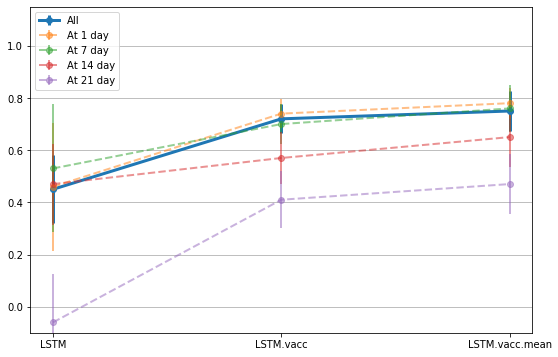

In [57]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="best_model_region_vacc.02122021.shallow."] = "LSTM.vacc"
y["cls"][y["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."] = "LSTM.vacc.mean"

y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="best_model_region_vacc.02122021.shallow."] = "LSTM.vacc"
error["cls"][error["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
plt.ylim(-0.1,1.15)
plt.legend(loc="upper left")
plt.grid(axis='y')
plt.show()

In [59]:
grp = dfPerf[["cls","dayPred","region","mape"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["mape_m"] = grp["mape"]["mean"]
grp["mape_m"] = grp["mape_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="mape_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                             dayPred
best_model_region_shallow.02122021.             -1         0.51
                                                 1         0.69
                                                 7         0.79
                                                 14        0.72
                                                 21        0.72
best_model_region_vacc.02122021.shallow.        -1         0.37
                                                 1         0.80
                                                 7         0.77
                                                 14        0.79
                                                 21        1.02
best_model_region_vacc_mean7.no_attn.02122021.  -1         0.40
                                                 1         0.78
                                                 7         0.71
                                                 14        0.84
                                                

cls                                             dayPred
best_model_region_shallow.02122021.             -1         0.07
                                                 1         0.18
                                                 7         0.47
                                                 14        0.33
                                                 21        0.28
best_model_region_vacc.02122021.shallow.        -1         0.06
                                                 1         0.25
                                                 7         0.28
                                                 14        0.23
                                                 21        0.52
best_model_region_vacc_mean7.no_attn.02122021.  -1         0.09
                                                 1         0.43
                                                 7         0.39
                                                 14        0.39
                                                

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

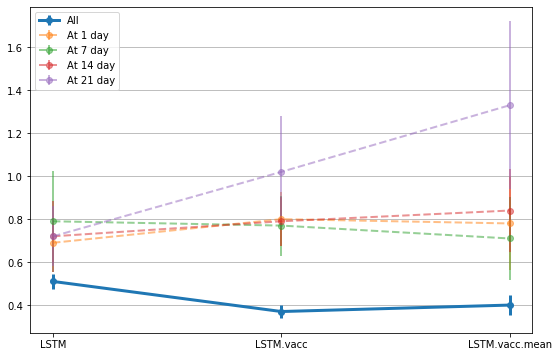

In [60]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="best_model_region_vacc.02122021.shallow."] = "LSTM.vacc"
y["cls"][y["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="best_model_region_vacc.02122021.shallow."] = "LSTM.vacc"
error["cls"][error["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
plt.legend(loc="upper left")
plt.grid(axis='y')
plt.show()

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

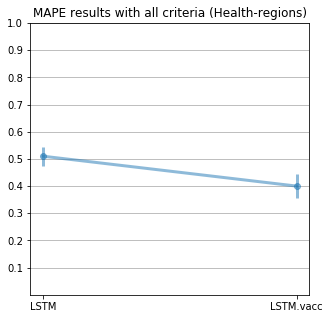

In [70]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="best_model_region_vacc.02122021.shallow."] = "LSTM.vacc"
y["cls"][y["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
yAll = yAll["score"]
yAll = yAll.iloc[[0,2]]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="best_model_region_vacc.02122021.shallow."] = "LSTM.vacc"
error["cls"][error["cls"]=="best_model_region_vacc_mean7.no_attn.02122021."] = "LSTM.vacc.mean"

error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
errorAll = errorAll["score"]
errorAll = errorAll.iloc[[0,2]]

plt.figure(figsize=(5,5))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3, alpha=0.5)
plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc"])
plt.title("MAPE results with all criteria (Health-regions)")
plt.grid(axis='y')
plt.yticks([0.1*i for i in range(1,11)])
plt.ylim(0,1)
plt.show()

In [31]:
grp = dfPerf[["cls","dayPred","region","mae"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["mae_m"] = grp["mae"]["mean"]
grp["mae_m"] = grp["mae_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="mae_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                             dayPred
best_model_region_shallow.02122021.             -1         50.38
                                                 1         38.53
                                                 7         42.72
                                                 14        46.97
                                                 21        51.86
best_model_region_vacc.02122021.shallow.        -1         26.19
                                                 1         24.07
                                                 7         26.47
                                                 14        35.44
                                                 21        44.11
best_model_region_vacc_mean7.no_attn.02122021.  -1         22.90
                                                 1         21.96
                                                 7         21.67
                                                 14        29.69
                                  

cls                                             dayPred
best_model_region_shallow.02122021.             -1         40.40
                                                 1         27.58
                                                 7         31.74
                                                 14        36.55
                                                 21        37.18
best_model_region_vacc.02122021.shallow.        -1         19.59
                                                 1         15.13
                                                 7         17.40
                                                 14        24.38
                                                 21        31.93
best_model_region_vacc_mean7.no_attn.02122021.  -1         15.49
                                                 1         14.50
                                                 7         13.51
                                                 14        20.38
                                  

/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

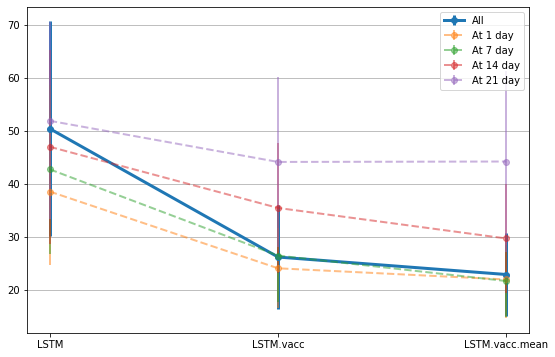

In [184]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
plt.legend(loc="upper right")
plt.grid(axis='y')
plt.show()

In [197]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","mape","mape_s"]].groupby(["cls","region"]).agg(["mean","std"]).reset_index()
grp["mape_m"] = grp["mape"]["mean"]
grp["mape_m"] = grp["mape_m"].astype(float)
grp["mape_std"] = grp["mape_s"]["mean"]
grp["mape_std"] = grp["mape_std"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mape_m")
display(pvt.iloc[2])
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mape_std")
display(pvt.iloc[2])

region
6100    0.38
6200    0.36
6300    0.29
6400    0.29
6700    0.41
7100    0.52
7801    0.36
7802    0.46
7803    0.54
Name: best_model_region_vacc_mean7.no_attn.02122021., dtype: float64

region
6100    0.39
6200    0.23
6300    0.28
6400    0.17
6700    0.34
7100    0.41
7801    0.29
7802    0.44
7803    0.55
Name: best_model_region_vacc_mean7.no_attn.02122021., dtype: float64

In [198]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","r2"]].groupby(["cls","region"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="r2_m")
display(pvt.iloc[2])

region
6100    0.87
6200    0.73
6300    0.40
6400    0.82
6700    0.76
7100    0.63
7801    0.85
7802    0.86
7803    0.84
Name: best_model_region_vacc_mean7.no_attn.02122021., dtype: float64

In [200]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","mae","mae_s"]].groupby(["cls","region"]).agg(["mean"]).reset_index()
grp["mae_m"] = grp["mae"]["mean"]
grp["mae_m"] = grp["mae_m"].astype(float)
grp["mae_std"] = grp["mae_s"]["mean"]
grp["mae_std"] = grp["mae_std"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mae_m")
display(pvt.iloc[2])
pvt_s = pd.pivot(grp, index=["cls"],columns="region",values="mae_std")
display(pvt_s.iloc[2])

region
6100    14.23
6200    13.94
6300     4.60
6400    30.43
6700    21.70
7100     3.74
7801    30.15
7802    50.32
7803    37.00
Name: best_model_region_vacc_mean7.no_attn.02122021., dtype: float64

region
6100    11.63
6200    10.17
6300     3.99
6400    24.19
6700    15.13
7100     2.64
7801    29.03
7802    33.14
7803    24.11
Name: best_model_region_vacc_mean7.no_attn.02122021., dtype: float64

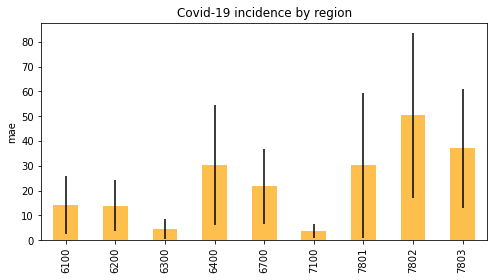

In [201]:
#pvt.iloc[[0,2,4]].plot(kind='bar',figsize=(15,6))
#plt.xticks(range(3),["LSTM","LSTM_VACC","LSTM_VACC_MEAN"])
pvt.iloc[2].plot(kind='bar',figsize=(8,4),color="orange",alpha=0.7,yerr=pvt_s.iloc[2])
plt.ylim(0,)
plt.ylabel("mae")
#plt.axhline(0.5,ls="--",c="black",linewidth=0.5)
plt.axhline(0.,ls="-",c="black",linewidth=1)
#plt.axhline(-0.5,ls="--",c="black",linewidth=0.5)
plt.title("Covid-19 incidence by region")
plt.xlabel("")
plt.show()

In [39]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","mae"]].groupby(["cls","region"]).agg(["mean","std"]).reset_index()
grp["mae_m"] = grp["mae"]["mean"]
grp["mae_m"] = grp["mae_m"].astype(float)
grp["mae_s"] = grp["mae"]["std"]
grp["mae_s"] = grp["mae_s"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mae_m")
print(pvt.values)
#pvt.iloc[[0,2,4]].plot(kind='bar',figsize=(15,6))
#plt.xticks(range(3),["LSTM","LSTM_VACC","LSTM_VACC_MEAN"])

[[ 184.95  204.42   88.99  585.28  491.33   69.57  691.14 1620.2  1072.58]]


In [113]:
grp = dfPerf[["cls","dayPred","r2"]].groupby(["cls","dayPred"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index="cls",columns="dayPred",values="r2_m")
display(pvt)
display(pvt.mean(axis=1))
display(pvt.std(axis=1))

dayPred,-1,1,7,14,21
cls,,,,,
best_model_region_shallow.02122021.,0.362222,0.457778,0.533333,0.465556,-0.062222
best_model_region_vacc.02122021.shallow.,0.557778,0.740000,0.704444,0.573333,0.413333
best_model_region_vacc_mean7.no_attn.02122021.,0.575556,0.777778,0.756667,0.646667,0.467778


cls
best_model_region_shallow.02122021.               0.351333
best_model_region_vacc.02122021.shallow.          0.597778
best_model_region_vacc_mean7.no_attn.02122021.    0.644889
dtype: float64

cls
best_model_region_shallow.02122021.               0.239086
best_model_region_vacc.02122021.shallow.          0.130213
best_model_region_vacc_mean7.no_attn.02122021.    0.128775
dtype: float64

([<matplotlib.axis.XTick at 0x14e17036bcf8>,
 [Text(0, 0, 'LSTM'), Text(1, 0, 'LSTM_VACC'), Text(2, 0, 'LSTM_VACC_MEAN')])

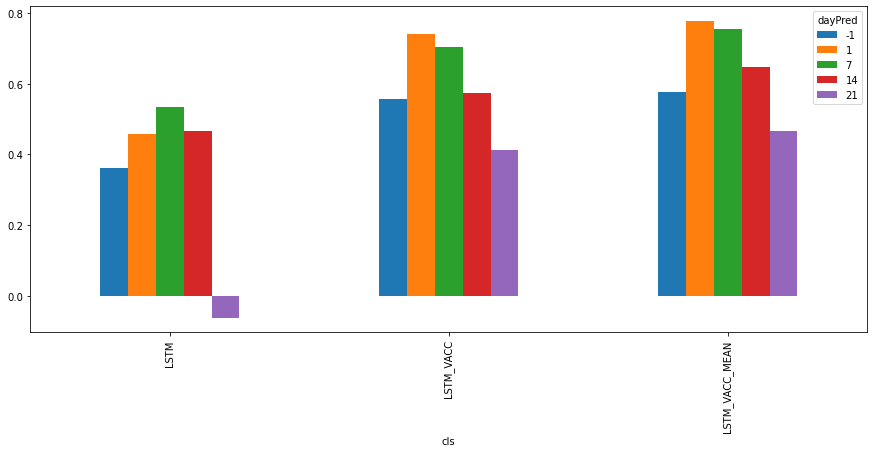

In [116]:
pvt.iloc[:,:].plot(kind='bar',figsize=(15,6))
plt.xticks(range(3),["LSTM","LSTM_VACC","LSTM_VACC_MEAN"])